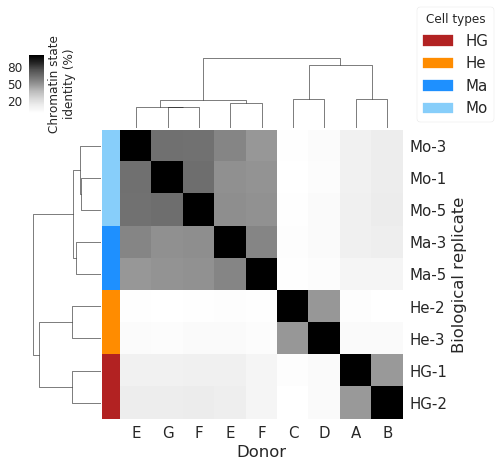

In [5]:
%matplotlib inline

import os as os
import collections as col
import pickle as pck
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stat

# What does this do?
# Plot a clustermap
# of all samples in
# the dataset based
# on chromatin state
# identity

date = '20180726'

run_plot_clustermap = True

save_figures = True
diss_version = True

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']
donor_labels = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/donor_char.json'))

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

dataset_root = os.path.join(fhgfs_base, 'sciddo', 'deep')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'

fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def make_clustermap(agreement, fkey, save_diss):
    """
    """
        
    cell_colors = {'Ma': 'dodgerblue', 'Mo': 'lightskyblue',
                   'He': 'darkorange', 'HG': 'firebrick'}
        
    agreement.index = [x[7:9] + '-' + x[3] for x in agreement.index]
    agreement.index.name = 'Biological replicate'
    
    agreement.columns = [x[7:9] + '-' + x[3] for x in agreement.columns]
    agreement.columns.name = 'Donor'
    
    agreement.columns = [donor_labels[x] for x in agreement.columns]
    agreement.columns.name = 'Donor'
    
    sample_colors = [cell_colors[x.split('-')[0]] for x in agreement.index]
                
    cm = sns.clustermap(agreement, method='average', metric='euclidean',
                        row_cluster=True, col_cluster=True,
                        cmap='Greys',
                        figsize=fig_sizes['two_col']['square'],
                        cbar_kws={'label': 'Chromatin state\nidentity (%)'},
                        row_colors=sample_colors)
    cm.cax.yaxis.label.set_size(12)
    cm.cax.yaxis.set_ticks([0.2, 0.5, 0.8])
    cm.cax.yaxis.set_ticklabels(['20', '50', '80'], fontsize=12)
    cm.cax.yaxis.tick_left()
        
    leg_cell = [patch.Patch(color=cell_colors[l], label=l) for l in sorted(cell_colors.keys())]
    
    leg = cm.ax_heatmap.legend(handles=leg_cell, loc='upper right',
                               bbox_to_anchor=(1.35, 1.45), frameon=True)
    leg.set_title('Cell types', prop={'size': 12})
    
    if not save_diss:
        tt = cm.ax_heatmap.set_title(fkey, fontsize=20)
        tt.set_position((-0.2, 1.4))
        exart = [tt, leg]
    else:
        exart = [leg]
                   
    return cm, exart
    
    
def plot_dataset_cluster():
    
    for root, dirs, datafile in os.walk(dataset_root):
        for df in datafile:
            if df.startswith('sciddo-data_') and df.endswith('.h5'):
                seg = df.split('.')[0].split('_')[-1]
                if seg == 'cmm18':
                    subfolder = fig_supp
                    fk = 'SX'
                else:
                    continue
                    #subfolder = fig_collect
                    #fk = 'SX'
                fpath = os.path.join(root, df)
                                
                with pd.HDFStore(fpath, 'r') as hdf:
                    sample_agreement = hdf['/statistic/agreement/score']

                fig, exart = make_clustermap(sample_agreement, fk, diss_version)
                
                if save_figures:
                    outname = 'fig_{}_data-cluster_{}'.format(fk, seg)
                    subfolder = fig_main
                    if diss_version:
                        subfolder = fig_diss

                    out_pdf = os.path.join(subfolder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(subfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
            
    return 0
        
    
if run_plot_clustermap:
    plot_dataset_cluster()